In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import h5py

In [2]:
photon_file = h5py.File("/kaggle/input/data-data/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5", "r")
electron_file = h5py.File("/kaggle/input/data-data/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5", "r")
X_photon = np.array(photon_file["X"])
y_photon = np.zeros(X_photon.shape[0], dtype=np.int64)
X_electron = np.array(electron_file["X"])
y_electron = np.ones(X_electron.shape[0], dtype=np.int64)
X = np.concatenate([X_photon, X_electron], axis=0)
y = np.concatenate([y_photon, y_electron], axis=0)

In [3]:
class EP_Dataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        image = torch.tensor(self.X[idx], dtype=torch.float32).permute(2, 0, 1)
        label = self.y[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [4]:
X_tensor = torch.tensor(X, dtype=torch.float32).permute(0, 3, 1, 2)
train_size = int(0.8 * len(X_tensor))
mean = X_tensor[:train_size].mean(dim=(0, 2, 3))
std = X_tensor[:train_size].std(dim=(0, 2, 3))

normalize = transforms.Normalize(mean=mean, std=std)
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.RandomRotation(10), normalize])
test_transform = transforms.Compose([normalize])


In [5]:
train_dataset = EP_Dataset(X[:train_size], y[:train_size], transform=train_transform)
test_dataset = EP_Dataset(X[train_size:], y[train_size:], transform=test_transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

In [6]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(nn.Conv2d(in_channels, out_channels, 1, stride, bias=False),
                                          nn.BatchNorm2d(out_channels))
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return F.relu(out)

In [7]:
class ResNet15(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(2, 32, 3, 1, 1), nn.BatchNorm2d(32), nn.ReLU())
        self.layer2 = ResidualBlock(32, 64, stride=2)
        self.layer3 = ResidualBlock(64, 128, stride=2)
        self.layer4 = ResidualBlock(128, 256, stride=2)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(256, num_classes)
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        return self.fc(x)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet15().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3)


In [9]:
for epoch in range(15):
    model.train()
    total_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Validation phase
    model.eval()
    all_preds, all_labels, all_probs = [], [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)[:, 1]
            preds = outputs.argmax(dim=1).cpu().numpy()
            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds)
    rec = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    print(f"Epoch {epoch+1:02d} | Loss: {total_loss/len(train_loader):.4f} | Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1 Score: {f1:.4f}")
    scheduler.step(acc)

Epoch 01 | Loss: 0.5877 | Accuracy: 0.5890 | Precision: 1.0000 | Recall: 0.5890 | F1 Score: 0.7413
Epoch 02 | Loss: 0.5486 | Accuracy: 0.6039 | Precision: 1.0000 | Recall: 0.6039 | F1 Score: 0.7530
Epoch 03 | Loss: 0.5400 | Accuracy: 0.6079 | Precision: 1.0000 | Recall: 0.6079 | F1 Score: 0.7561
Epoch 04 | Loss: 0.5350 | Accuracy: 0.6615 | Precision: 1.0000 | Recall: 0.6615 | F1 Score: 0.7962
Epoch 05 | Loss: 0.5316 | Accuracy: 0.5754 | Precision: 1.0000 | Recall: 0.5754 | F1 Score: 0.7305
Epoch 06 | Loss: 0.5287 | Accuracy: 0.6081 | Precision: 1.0000 | Recall: 0.6081 | F1 Score: 0.7563
Epoch 07 | Loss: 0.5261 | Accuracy: 0.5975 | Precision: 1.0000 | Recall: 0.5975 | F1 Score: 0.7480
Epoch 08 | Loss: 0.5246 | Accuracy: 0.6469 | Precision: 1.0000 | Recall: 0.6469 | F1 Score: 0.7856
Epoch 09 | Loss: 0.5146 | Accuracy: 0.6563 | Precision: 1.0000 | Recall: 0.6563 | F1 Score: 0.7925
Epoch 10 | Loss: 0.5131 | Accuracy: 0.6166 | Precision: 1.0000 | Recall: 0.6166 | F1 Score: 0.7628
Epoch 11 |

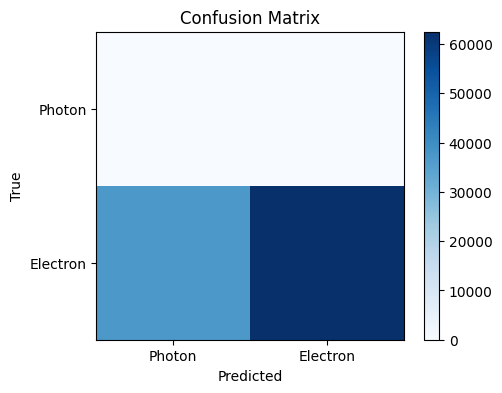

In [10]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(5, 4))
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.xticks([0, 1], ["Photon", "Electron"])
plt.yticks([0, 1], ["Photon", "Electron"])
plt.show()

Accuracy: 0.6272
Precision: 1.0000
Recall: 0.6272
F1 Score: 0.7709


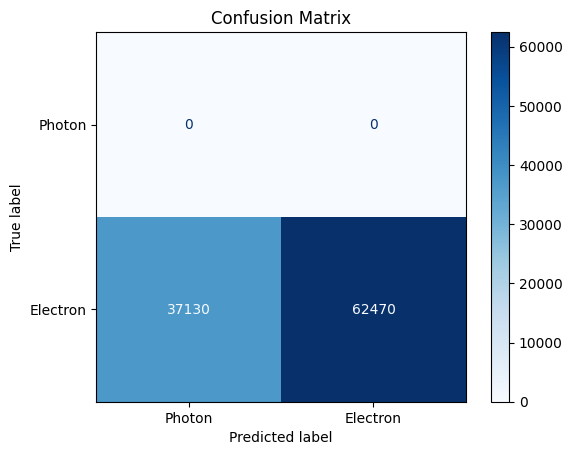

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1020: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:97: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


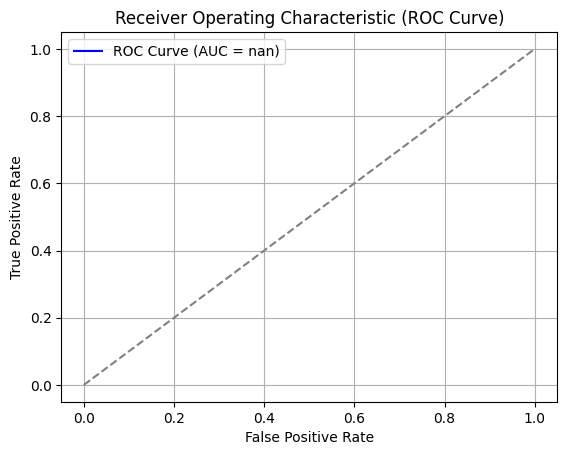

In [11]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt

# --- Metrics Calculation ---
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# --- Confusion Matrix ---
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Photon", "Electron"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# --- ROC Curve ---
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC Curve)")
plt.legend()
plt.grid(True)
plt.show()
